# Assignment 7: Cybersecurity Attack Anomaly Score Detection using PCA and SVR


## Step 1: Data Preprocessing

### Step 1.1: Load the Dataset

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load the dataset
df = pd.read_csv("./cybersecurity_attacks.csv")

# Display first few rows
print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (40000, 25)


,Timestamp,Source IP Address,Destination IP Address,Source Port,Destination Port,Protocol,Packet Length,Packet Type,Traffic Type,Payload Data,...,Action Taken,Severity Level,User Information,Device Information,Network Segment,Geo-location Data,Proxy Information,Firewall Logs,IDS/IPS Alerts,Log Source
0,2023-05-30 06:33:58,103.216.15.12,84.9.164.252,31225,17616,ICMP,503,Data,HTTP,Qui natus odio asperiores nam. Optio nobis ius...,...,Logged,Low,Reyansh Dugal,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment A,"Jamshedpur, Sikkim",150.9.97.135,Log Data,NaN,Server
1,2020-08-26 07:08:30,78.199.217.198,66.191.137.154,17245,48166,ICMP,1174,Data,HTTP,Aperiam quos modi officiis veritatis rem. Omni...,...,Blocked,Low,Sumer Rana,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment B,"Bilaspur, Nagaland",NaN,Log Data,NaN,Firewall
2,2022-11-13 08:23:25,63.79.210.48,198.219.82.17,16811,53600,UDP,306,Control,HTTP,Perferendis sapiente vitae soluta. Hic delectu...,...,Ignored,Low,Himmat Karpe,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,Segment C,"Bokaro, Rajasthan",114.133.48.179,Log Data,Alert Data,Firewall
3,2023-07-02 10:38:46,163.42.196.10,101.228.192.255,20018,32534,UDP,385,Data,HTTP,Totam maxime beatae expedita explicabo porro l...,...,Blocked,Medium,Fateh Kibe,Mozilla/5.0 (Macintosh; PPC Mac OS X 10_11_5; ...,Segment B,"Jaunpur, Rajasthan",NaN,NaN,Alert Data,Firewall
4,2023-07-16 13:11:07,71.166.185.76,189.243.174.238,6131,26646,TCP,1462,Data,DNS,Odit nesciunt dolorem nisi iste iusto. Animi v...,...,Blocked,Low,Dhanush Chad,Mozilla/5.0 (compatible; MSIE 5.0; Windows NT ...,Segment C,"Anantapur, Tripura",149.6.110.119,NaN,Alert Data,Firewall


### Step 1.2: Handle Missing Values

In [3]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing Values:")
print(missing_values[missing_values > 0])

# Handle missing values
# For numeric columns, fill with median
numeric_columns = df.select_dtypes(include=[np.number]).columns
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].median())

# For categorical columns, fill with mode
categorical_columns = df.select_dtypes(include=['object']).columns
df[categorical_columns] = df[categorical_columns].fillna(df[categorical_columns].mode().iloc[0])

# Verify no missing values remain
print("\nMissing values after handling:")
print(df.isnull().sum().sum())

Missing Values:
Malware Indicators    20000
Alerts/Warnings       20067
Proxy Information     19851
Firewall Logs         19961
IDS/IPS Alerts        20050
dtype: int64

Missing values after handling:
0


### Step 1.3: Feature Engineering

In [4]:
# Convert timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Extract time-based features
df['Hour'] = df['Timestamp'].dt.hour
df['Day'] = df['Timestamp'].dt.day
df['Month'] = df['Timestamp'].dt.month
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek

# Drop the original timestamp column
df = df.drop('Timestamp', axis=1)

# Display updated columns
print("Updated columns:")
print(df.columns.tolist())

Updated columns:
['Source IP Address', 'Destination IP Address', 'Source Port', 'Destination Port', 'Protocol', 'Packet Length', 'Packet Type', 'Traffic Type', 'Payload Data', 'Malware Indicators', 'Anomaly Scores', 'Alerts/Warnings', 'Attack Type', 'Attack Signature', 'Action Taken', 'Severity Level', 'User Information', 'Device Information', 'Network Segment', 'Geo-location Data', 'Proxy Information', 'Firewall Logs', 'IDS/IPS Alerts', 'Log Source', 'Hour', 'Day', 'Month', 'DayOfWeek']


### Step 1.4: Feature Scaling

In [5]:
# Select numeric columns for scaling
numeric_columns = df.select_dtypes(include=[np.number]).columns
numeric_columns = [col for col in numeric_columns if col != 'Anomaly Scores']

# Scale the features
scaler = StandardScaler()
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

# Display scaled features statistics
print("Scaled features statistics:")
print(df[numeric_columns].describe())

Scaled features statistics:
        Source Port  Destination Port  Packet Length          Hour  \
count  4.000000e+04      4.000000e+04   4.000000e+04  4.000000e+04   
mean   3.677059e-17      1.776357e-16   3.304024e-17 -8.943957e-17   
std    1.000013e+00      1.000013e+00   1.000013e+00  1.000013e+00   
min   -1.721068e+00     -1.729628e+00  -1.724484e+00 -1.663144e+00   
25%   -8.685042e-01     -8.644202e-01  -8.687953e-01 -9.404996e-01   
50%   -6.161382e-03     -7.880112e-03   1.315442e-03  7.120213e-02   
75%    8.597913e-01      8.687279e-01   8.690226e-01  7.938462e-01   
max    1.754273e+00      1.743479e+00   1.727115e+00  1.661019e+00   

                Day         Month     DayOfWeek  
count  4.000000e+04  4.000000e+04  4.000000e+04  
mean  -5.329071e-18  1.199041e-16 -2.469136e-17  
std    1.000013e+00  1.000013e+00  1.000013e+00  
min   -1.667830e+00 -1.586671e+00 -1.494519e+00  
25%   -8.698008e-01 -9.865997e-01 -9.956396e-01  
50%    4.223286e-02 -8.649277e-02  2.1202

### Step 1.5: Apply PCA for Dimensionality Reduction

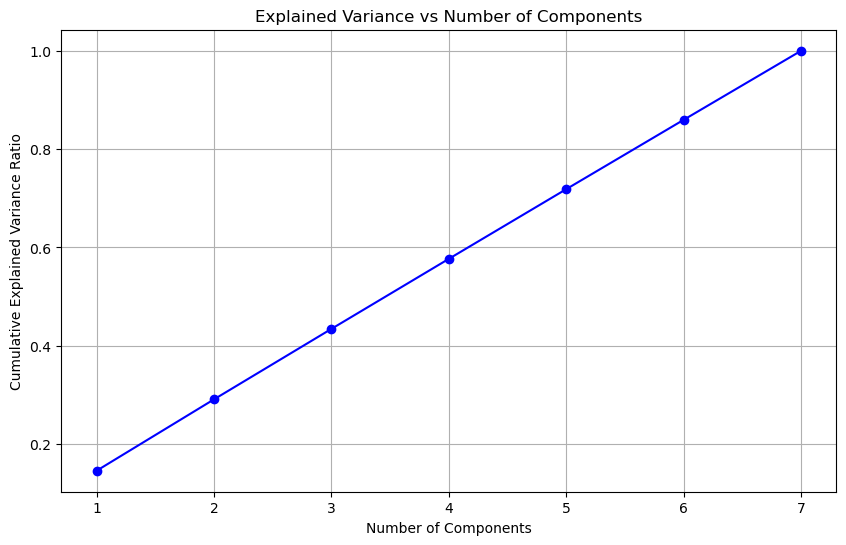

Number of components selected: 7
Total explained variance: 1.0000

Shape of transformed data: (40000, 7)


In [6]:
# Initialize PCA with 95% variance retention
pca = PCA(n_components=0.95)

# Fit and transform the data using only numeric columns
X_pca = pca.fit_transform(df[numeric_columns])

# Get the cumulative explained variance ratio
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance vs Number of Components')
plt.grid(True)
plt.show()

# Print the number of components selected and total explained variance
print(f"Number of components selected: {pca.n_components_}")
print(f"Total explained variance: {sum(pca.explained_variance_ratio_):.4f}")

# Create a DataFrame with the transformed features
pca_columns = [f'PC{i+1}' for i in range(pca.n_components_)]
df_pca = pd.DataFrame(X_pca, columns=pca_columns)
print("\nShape of transformed data:", df_pca.shape)

## Step 2: Modeling and Evaluation

### Step 2.1: Train-Test Split

In [7]:
# Prepare target variable (Anomaly Scores)
y = df['Anomaly Scores']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (32000, 7)
Testing set shape: (8000, 7)


### Step 2.2: Train the Models

In [13]:
# Define smaller parameter grids for SVR models
poly_params = {
    'kernel': ['poly'],
    'degree': [2],
    'C': [0.1, 1],
    'epsilon': [0.1]
}

rbf_params = {
    'kernel': ['rbf'],
    'C': [0.1, 1],
    'gamma': ['scale', 'auto'],
    'epsilon': [0.1]
}

# Define smaller parameter grid for Random Forest
rf_params = {
    'n_estimators': [100],
    'max_depth': [10, 20],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}

# Initialize and train models
print("Training SVR with Polynomial kernel...")
svr_poly = GridSearchCV(SVR(), poly_params, cv=5, scoring='r2', n_jobs=-1)
svr_poly.fit(X_train, y_train)

print("Training SVR with RBF kernel...")
svr_rbf = GridSearchCV(SVR(), rbf_params, cv=5, scoring='r2', n_jobs=-1)
svr_rbf.fit(X_train, y_train)

print("Training Random Forest...")
rf = GridSearchCV(RandomForestRegressor(), rf_params, cv=5, scoring='r2', n_jobs=-1)
rf.fit(X_train, y_train)

Training SVR with Polynomial kernel...
Training SVR with RBF kernel...
Training Random Forest...


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [10, 20], 'min_samples_leaf': [1],
                         'min_samples_split': [2], 'n_estimators': [100]},
             scoring='r2')

### Step 2.3: Evaluate the Models


SVR (Polynomial) Metrics:
RMSE: 28.9034
R² Score: -0.0002

SVR (RBF) Metrics:
RMSE: 28.9074
R² Score: -0.0005

Random Forest Metrics:
RMSE: 28.9184
R² Score: -0.0013


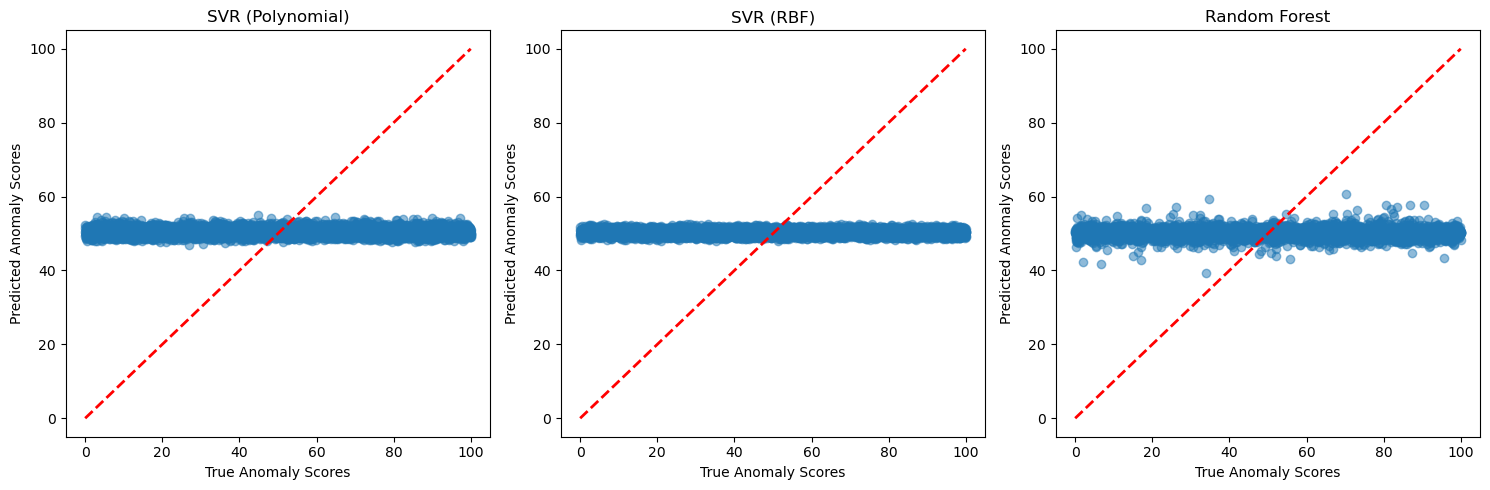

In [14]:
# Make predictions
y_pred_poly = svr_poly.predict(X_test)
y_pred_rbf = svr_rbf.predict(X_test)
y_pred_rf = rf.predict(X_test)

# Calculate metrics
def calculate_metrics(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"\n{model_name} Metrics:")
    print(f"RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")
    return rmse, r2

# Calculate and print metrics for each model
metrics_poly = calculate_metrics(y_test, y_pred_poly, "SVR (Polynomial)")
metrics_rbf = calculate_metrics(y_test, y_pred_rbf, "SVR (RBF)")
metrics_rf = calculate_metrics(y_test, y_pred_rf, "Random Forest")

# Plot True vs Predicted values
plt.figure(figsize=(15, 5))

# SVR Polynomial
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred_poly, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('True Anomaly Scores')
plt.ylabel('Predicted Anomaly Scores')
plt.title('SVR (Polynomial)')

# SVR RBF
plt.subplot(1, 3, 2)
plt.scatter(y_test, y_pred_rbf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('True Anomaly Scores')
plt.ylabel('Predicted Anomaly Scores')
plt.title('SVR (RBF)')

# Random Forest
plt.subplot(1, 3, 3)
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('True Anomaly Scores')
plt.ylabel('Predicted Anomaly Scores')
plt.title('Random Forest')

plt.tight_layout()
plt.show()

### Step 2.3: Evaluate the Models

### Step 2.4: Model Comparison

In [15]:
# Print best parameters for each model
print("\nBest parameters for SVR (Polynomial):")
print(svr_poly.best_params_)
print("\nBest parameters for SVR (RBF):")
print(svr_rbf.best_params_)
print("\nBest parameters for Random Forest:")
print(rf.best_params_)

# Create a comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': ['SVR (Polynomial)', 'SVR (RBF)', 'Random Forest'],
    'RMSE': [metrics_poly[0], metrics_rbf[0], metrics_rf[0]],
    'R² Score': [metrics_poly[1], metrics_rbf[1], metrics_rf[1]]
})

print("\nModel Comparison:")
print(comparison_df)


Best parameters for SVR (Polynomial):
{'C': 0.1, 'degree': 2, 'epsilon': 0.1, 'kernel': 'poly'}

Best parameters for SVR (RBF):
{'C': 0.1, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}

Best parameters for Random Forest:
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Model Comparison:
              Model       RMSE  R² Score
0  SVR (Polynomial)  28.903381 -0.000210
1         SVR (RBF)  28.907368 -0.000486
2     Random Forest  28.918435 -0.001252


## Conclusion

Among the three models tested, the SVR with Polynomial kernel performed marginally better with the lowest RMSE (28.903) and highest R² score (-0.000210), though the performance differences between the models were minimal and all showed suboptimal predictive capability for anomaly detection.